# **Preprocessing and clustering 3k PBMCs**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/distances.py:

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [4]:
results_file = '/home/asus/Desktop/CHRF_Project/Single_cell/8_Scanpy/Jupyter_Note/write/pbmc3k.h5ad'  # the file that will store the analysis results

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [5]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


<div class="alert alert-info">

**Note**
    
See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.

</div>

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### 

### **Show the matrix.mtx**

In [9]:
import pandas as pd

# To read the Matrix Market (.mtx) file into a DataFrame, you can use:
df = pd.read_csv('/home/asus/Desktop/CHRF_Project/Single_cell/8_Scanpy/Jupyter_Note/data/filtered_gene_bc_matrices/hg19/matrix.mtx', sep=' ')

# Print the head of the DataFrame with 5 rows
print(df.head(5))




  %%MatrixMarket  matrix  coordinate  real  general
0              %     NaN         NaN   NaN      NaN
1          32738  2700.0   2286884.0   NaN      NaN
2          32709     1.0         4.0   NaN      NaN
3          32707     1.0         1.0   NaN      NaN
4          32706     1.0        10.0   NaN      NaN


/tmp/ipykernel_32901/4010980920.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/asus/Desktop/CHRF_Project/Single_cell/8_Scanpy/Jupyter_Note/data/filtered_gene_bc_matrices/hg19/matrix.mtx', sep=' ')


* The given matrix appears to be in the **Matrix Market format** and represents a sparse matrix 
* %%MatrixMarket: This line indicates that the file is in the Matrix Market format
* matrix: This specifies that the matrix is a general matrix, meaning it can contain any real values.
* coordinate: This indicates that the matrix is represented in coordinate format. Each nonzero entry of the matrix is represented by its row index, column index, and value.
* real: This specifies that the values in the matrix are real numbers.
* general: This indicates that the matrix is a general matrix, meaning it can contain any real values.
* Row 0: This row appears to be a comment indicated by the '%' symbol. It doesn't contain any meaningful data.
* Rows 1 to end: These rows represent the nonzero entries of the matrix.

### **Show the genes.tsv** ###

In [10]:
num_rows = df.shape[0]
num_cols = df.shape[1]

print("Total rows: ", num_rows)
print("Total columns: ", num_cols)

Total rows:  2286886
Total columns:  5


* the first column represents the gene IDs (presumably in the format ENSG00000xxxxx), and 
* the second column represents the gene names or symbols. 
* Each row in the file corresponds to a specific gene. 

Here's an overview of the data in the file:

| Gene ID          | Gene Name    |
|------------------|--------------|
| ENSG00000243485  | MIR1302-10   |
| ENSG00000237613  | FAM138A      |
| ENSG00000186092  | OR4F5        |
| ENSG00000238009  | RP11-34P13.7 |

In this example, the first row contains the gene ID "ENSG00000243485" and the corresponding gene name "MIR1302-10." Similarly, the following rows contain gene ID-gene name


In [13]:
import pandas as pd

# To read the Matrix Market (.mtx) file into a DataFrame, you can use:
df = pd.read_csv('/home/asus/Desktop/CHRF_Project/Single_cell/8_Scanpy/Jupyter_Note/data/filtered_gene_bc_matrices/hg19/genes.tsv', sep='\t')

# Print the head of the DataFrame with 5 rows
print(df.head(5))

   ENSG00000243485    MIR1302-10
0  ENSG00000237613       FAM138A
1  ENSG00000186092         OR4F5
2  ENSG00000238009  RP11-34P13.7
3  ENSG00000239945  RP11-34P13.8
4  ENSG00000237683    AL627309.1


## **Preprocess** ##

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* sc.pl.highest_expr_genes()

**Why need to show top highly expressed genes  within dataset at single cell rna seq analysis?**

>* The function is used in single-cell RNA sequencing (scRNA-seq) analysis to identify and visualize the top highly expressed genes across all cells in the dataset.

>>* In scRNA-seq, cells can have different gene expression profiles, with some genes being highly expressed in certain cells and lowly expressed or not expressed at all in others. 
>>* By identifying the most highly expressed genes across all cells, we can gain insight into the underlying biology of the cells and potentially identify new biomarkers or therapeutic targets.
>>*  plots a heatmap of the expression levels of the top n_top genes that are expressed at the highest level across all cells in the dataset. 

normalizing counts per cell
    finished (0:00:00)


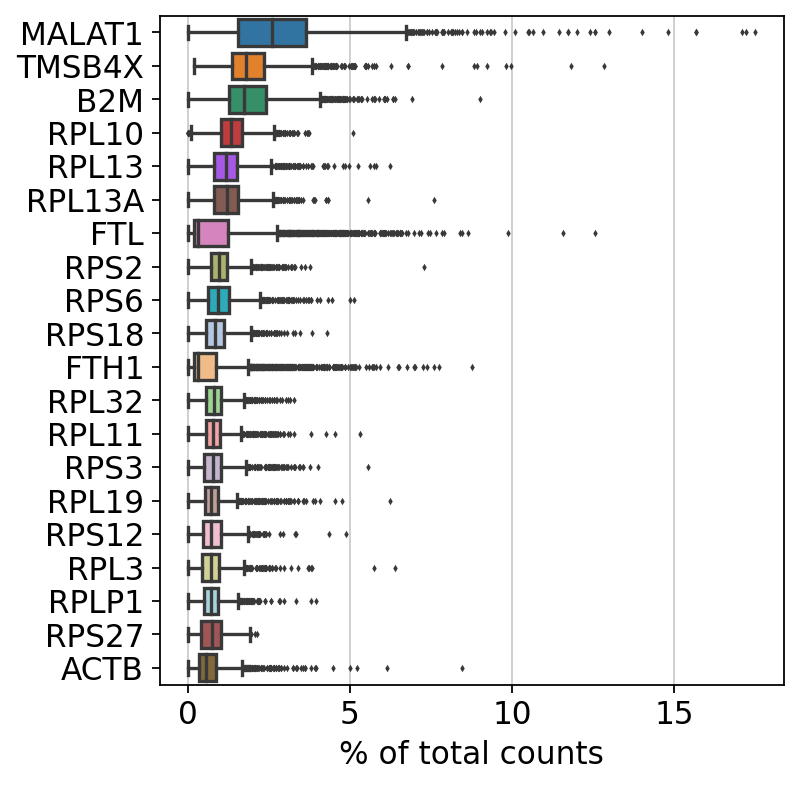

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

#### **Basic filtering:**

* **sc.pp.filter_cells(adata, min_genes=200)**
>* sc.pp.filter_cells(adata, min_genes=200), cells that have expression values for at least 200 genes or more will be retained, 
>* while cells with expression values for fewer than 200 genes will be filtered out and removed from the dataset.
* **sc.pp.filter_genes(adata, min_cells=3)**

**Why need to filter out low-quality cells and lowly expressed genes for single cell rna seq analysis ?**



> * In scRNA-seq, each cell is sequenced separately, resulting in a dataset with many cells and genes. 
> * However, not all cells or genes in the dataset are of equal quality or importance. 
> * Some cells may have low RNA content or may be in the process of dying, while some genes may be expressed at very low levels and may not provide useful information for downstream analyses.

>> * By filtering out low-quality cells and lowly expressed genes, we can improve the quality of the scRNA-seq data and increase the accuracy of downstream analyses. 

In [10]:
sc.pp.filter_cells(adata, min_genes=200)

In [11]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [12]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* **adata.var['mt'] = adata.var_names.str.startswith('MT-')**  # annotate the group of mitochondrial genes as 'mt'

**Why need to identify Mitochondrial gene (start with the prefix 'MT-') in the single cell rna seq analysis?**

>* Mitochondria are organelles found within cells that are responsible for producing energy in the form of ATP through oxidative phosphorylation. 
>* However, Mitochondrial dysfunction can lead to a variety of cellular stresses, including oxidative stress and inflammation, and can contribute to a variety of diseases such as neurodegeneration, diabetes, and cancer.
>*  Cells with high levels of mitochondrial gene expression may indicate poor quality or damaged cells, and may need to be filtered out of downstream analyses.
>* Mitochondrial genes are important to annotate(labeling with the mitochondrial gene) because they can indicate potential sources of technical variation and can also be used as quality control metrics.
>>* **What is the problem with highly expressed Mitochondrial gene (start with the prefix 'MT-') for the single cell rna seq analysis?**
>>>* Cells with high levels of mitochondrial gene expression may have reduced RNA quality, which can lead to an increase in technical noise and a decrease in the accuracy of gene expression measurements. 
>>>* In addition, cells with high levels of mitochondrial gene expression may have altered gene expression patterns that are unrelated to the biological question being investigated, which can lead to spurious results.

>>>* To address these issues, it is common practice in scRNA-seq analysis to filter out cells with high levels of mitochondrial gene expression or to correct for mitochondrial gene expression in downstream analyses. 
>>>* This can help improve the quality and reliability of the scRNA-seq data and increase the accuracy of downstream analyses.

>* The function identify genes that start with the prefix 'MT-', which is typically used to denote mitochondrial genes in gene annotations.
>* The resulting boolean vector is stored in **a new column called 'mt'** in the var attribute of the AnnData object. 
>* **The value of this column will be True for mitochondrial genes and False for all other genes in the dataset.**
>* Within the **adata** will added a extra column name as **mt**   

In [13]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [15]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells', 'mt'

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

* **sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)**
>>* qc_vars=['mt'] :  A list of mitochondrial genes
>>* percent_top=None: All genes will be used
>>>* Additional QC metrics

>>>>* Common additional QC metrics may include:

>>>>>* Percentage of mitochondrial genes: This metric measures the percentage of gene expression attributed to mitochondrial genes. High percentages may indicate mitochondrial dysfunction or cell stress.

>>>>>* Percentage of ribosomal genes: This metric measures the percentage of gene expression attributed to ribosomal genes. Elevated percentages may suggest high levels of cellular protein synthesis.

>>>>>* Percentage of housekeeping genes: This metric quantifies the percentage of gene expression contributed by housekeeping genes, which are typically constitutively expressed across cell types and perform essential cellular functions.

>>>>*  additional QC metrics, researchers gain a more comprehensive understanding of the cellular composition, quality, and potential biases in the scRNA-seq data, enabling them to make informed decisions regarding cell filtering, normalization, batch correction, clustering, or downstream analysis strategies.

>>>* When the percent_top parameter is specified with a value (e.g., percent_top=10), additional QC metrics related to the percentage of top-expressed genes will be computed. 
>>>* The function determines the expression threshold for the top-expressed genes by selecting the genes with the highest expression levels in each cell, considering the specified percentage.
>>* log1p: take the natural logarithm of the expression values and add 1 before calculating the QC metrics. By default, this is set to False.
>>>* The reason for adding 1 to the expression values before taking the logarithm is to avoid issues with cells that have very low expression values. 
>>* inplace=True: The modify the adata object in place or return a new object with the calculated metrics. By default, this is set to True, which means that the adata object will be modified in place.

**How create and calculate QC metric from the mitrocondroil gene expression column. Explain mathmatically and formula?**

>* QC metrics are measures of data quality that can be used to identify and remove low-quality or problematic cells from the dataset.
>* The mitochondrial gene percentage is often used as a QC metric in scRNA-seq analysis, as high percentages can indicate low RNA quality or other technical issues.
>>* First, you need to retrieve the expression values for mitochondrial genes for each cell in your scRNA-seq dataset.
>>* Calculate the total mitochondrial gene expression for each cell by summing the expression values for all mitochondrial genes.
>>* Calculate metric for each cell by
>>>* dividing the total mitochondrial gene expression by the total gene expression for that cell and multiplying by 100. 
>>>* This will give you the percentage of mitochondrial gene expression for each cell, which can be used as a QC metric.

>>>* QC metric = (total mitochondrial gene expression / total gene expression) * 100


In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [17]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* **sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)**

**Explanation:**

>* sc.pl.violin(): Generates violin plots to visualize the distribution of QC metrics for cells in a single-cell RNA sequencing (scRNA-seq) dataset. 
>>* The function takes as input an AnnData object adata that contains the expression data for each cell, and a list of QC metrics that you want to plot.
>>* This function plot three QC metrics: n_genes_by_counts, total_counts, and pct_counts_mt. 
>>>* These metrics correspond to 
>>>>* the number of genes detected per cell, 
>>>>* the total number of counts (i.e., expression values) per cell, and 
>>>>* the percentage of counts that come from mitochondrial genes per cell, respectively.
>* adata: An AnnData object containing the expression data for each cell.
>* vars: A list of variable names that correspond to QC metrics that you want to plot.
>* jitter: The amount of jitter to add to the data points along the x-axis to make them more visible. By default, this is set to 0.4.
>* multi_panel: Whether to generate a separate plot for each variable or a single plot with multiple panels. By default, this is set to True, which means that multiple panels will be generated.
-----------------------------------------------------------
>* The height of the violin plot corresponds to the density of cells with a particular value of the metric, and 
>* The width of the plot represents the range of values for the metric. 
>* The median value of the metric is indicated by a horizontal line inside the plot. 
>* The violin plot can be useful for identifying any outliers or patterns in the distribution of QC metrics

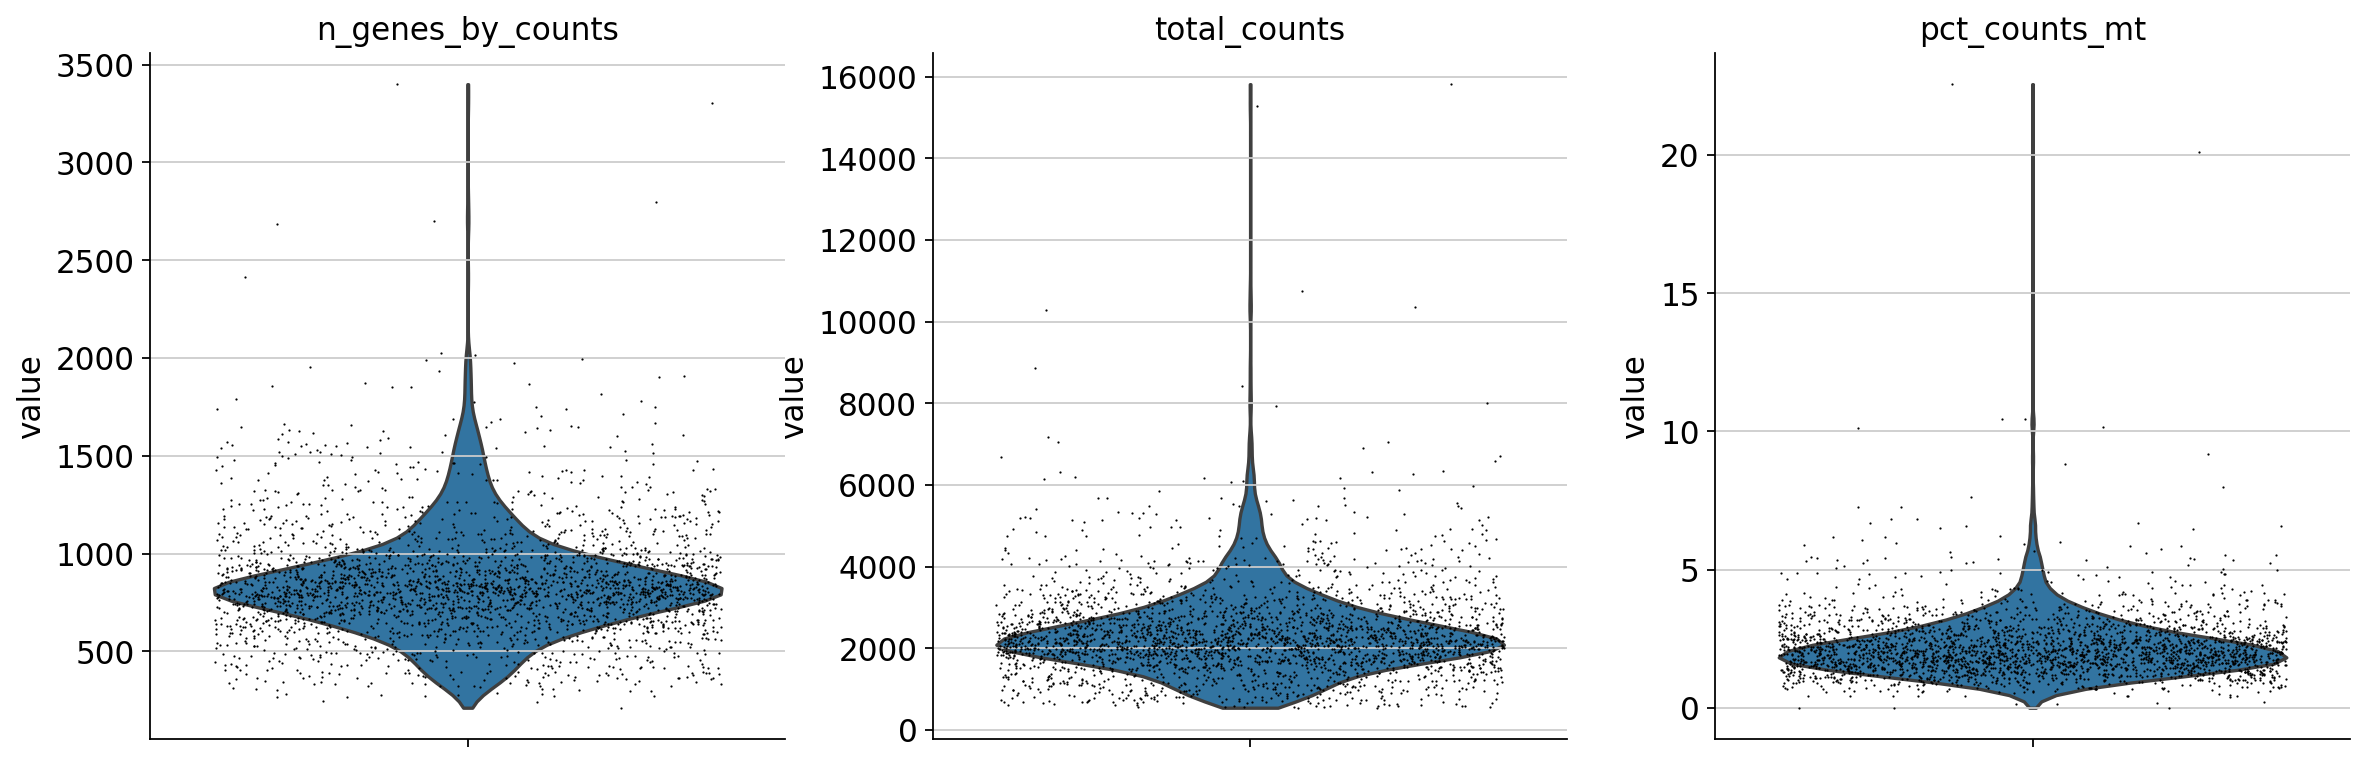

In [18]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Remove cells that have too many mitochondrial genes expressed or too many total counts:**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
>* pct_counts_mt" refers to the percentage of reads in a single-cell RNA sequencing (scRNA-seq) sample that are derived from mitochondrial genes.

>* In single-cell RNA sequencing (scRNA-seq), the total number of counts (i.e., expression values) per cell is a measure of the total amount of RNA that was sequenced for that cell. 
>>* This can be affected by various factors, such as the quality of the RNA, the sequencing depth, and the efficiency of the library preparation and sequencing process. Cells with higher total counts are generally considered to be of higher quality, since they contain more information about the transcriptional profile of the cell.
>* Plotting the total_counts variable on the x-axis and the pct_counts_mt variable on the y-axis allows us to examine the relationship between 
>>* the overall quality of the cells (as indicated by the total counts) and 
>>* the potential mitochondrial contamination (as indicated by the proportion of mitochondrial RNA). 
>* In general, we expect cells with higher total counts to have lower levels of mitochondrial contamination, since there is more RNA in the cell that is not derived from mitochondria. However, cells with very high levels of mitochondrial gene expression can be indicative of mitochondrial contamination, and may need to be filtered out of the dataset.

>* Overall, this plot can help us identify problematic cells with high mitochondrial contamination, as well as cells with lower overall RNA content that may have low quality or are otherwise unsuitable for downstream analysis.

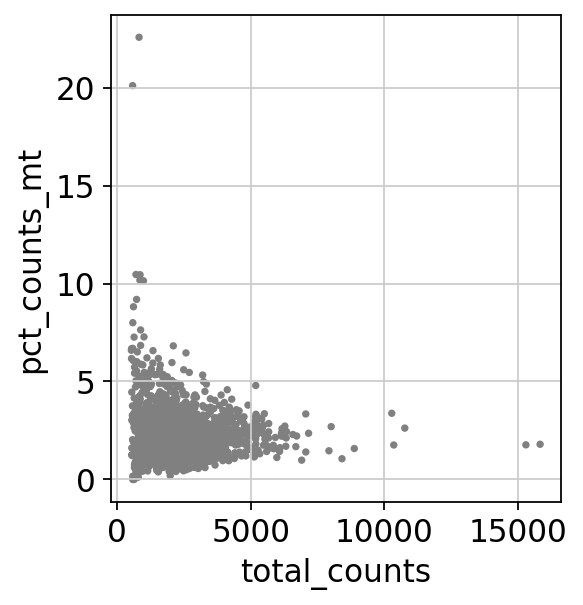

In [19]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

* sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

>* The total number of counts (i.e., expression values) per cell is a measure of the total amount of RNA that was sequenced for that cell. 
>* "n_genes_by_counts" refers to the number of genes that have been detected in each cell based on the count data.



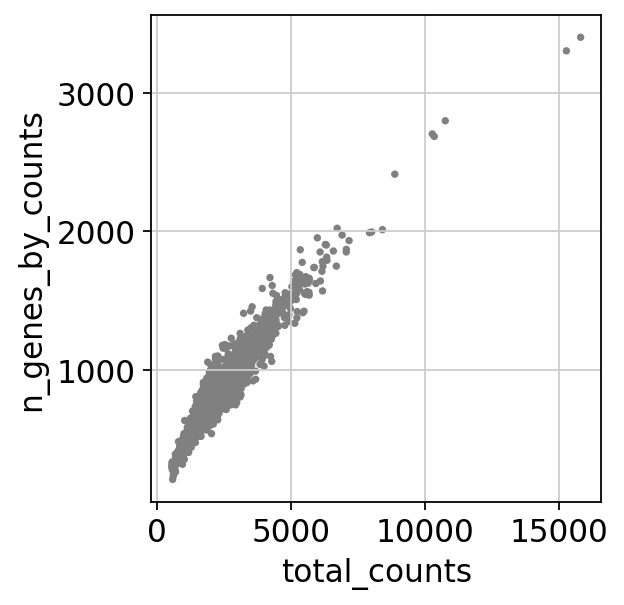

In [20]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Actually do the filtering by slicing the `AnnData` object.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* adata = adata[adata.obs.n_genes_by_counts < 2500, :]

>* Above code:
>>* filters the cells in a single-cell RNA sequencing (scRNA-seq) dataset stored in an AnnData object ("adata") based on the number of genes detected in each cell ("n_genes_by_counts").
>>* Selects only the cells in the dataset where
>>>* the value of "n_genes_by_counts" is less than 2500. 
>>* This is achieved by using boolean indexing: adata.obs.n_genes_by_counts < 2500 returns a boolean mask indicating which cells have "n_genes_by_counts" values less than 2500, and 
>>>* this mask is used to select only those cells from the original AnnData object.
>>* This type of filtering is commonly used to remove low-quality or empty cells from an scRNA-seq dataset, as cells with very low gene expression are likely to be noise or technical artifacts rather than biologically relevant cells.

In [21]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [22]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 2695 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

* adata = adata[adata.obs.pct_counts_mt < 5, :]


>* The code filters the cells in a single-cell RNA sequencing (scRNA-seq) dataset stored in an AnnData object ("adata") based on 
>>* the percentage of counts derived from mitochondrial genes in each cell ("pct_counts_mt").

>* Specifically, this command selects only the cells in the dataset where the value of "pct_counts_mt" is less than 5%. 
>* This is achieved by using boolean indexing: adata.obs.pct_counts_mt < 5 returns a boolean mask indicating which cells have "pct_counts_mt" values less than 5%, and this mask is used to select only those cells from the original AnnData object.

>* This type of filtering is commonly used to remove cells with high levels of mitochondrial contamination from an scRNA-seq dataset, as mitochondrial genes are not typically of interest in most gene expression analyses and may interfere with downstream analysis. Cells with high "pct_counts_mt" values are likely to be contaminated with mitochondrial RNA or other technical artifacts, and may not represent biologically meaningful cells.

>* By filtering out cells with high "pct_counts_mt" values, this command can improve the quality and specificity of downstream analysis in an scRNA-seq dataset. The specific threshold used for filtering (in this case, 5%) may vary depending on the experimental design and sequencing platform.

In [24]:
adata

View of AnnData object with n_obs × n_vars = 2695 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [25]:
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [26]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* sc.pp.normalize_total(adata, target_sum=1e4)
>* Normalization is a necessary step in scRNA-seq data analysis because the number of sequencing reads obtained from each cell can vary significantly due to technical factors such as differences in sequencing depth and library size. 
>* Normalization is required to adjust for these technical differences and ensure that the data is comparable between cells.
>* There are different normalization methods used in scRNA-seq data analysis, such as:
>>* **Total Count normalization:** This method normalizes each cell's gene expression count by its total number of counts (i.e., reads or UMIs) and scales the counts to a common scale such as 10,000. The purpose is to adjust for differences in sequencing depth and library size between cells.
>>* **Library Size normalization:** This method scales the total number of counts in each cell to a common value by dividing the count of each gene by the total count of the corresponding cell. The purpose is to adjust for differences in library size between cells.
>>* **Median normalization:** This method scales each cell's gene expression count by the median count across all cells. The purpose is to adjust for technical noise and batch effects.
>* **Total Count normalization** is a simple and effective method for adjusting for technical differences between cells. It has been widely used in scRNA-seq data analysis and is often the default normalization method in many software packages.


In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)
adata

normalizing counts per cell
    finished (0:00:00)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

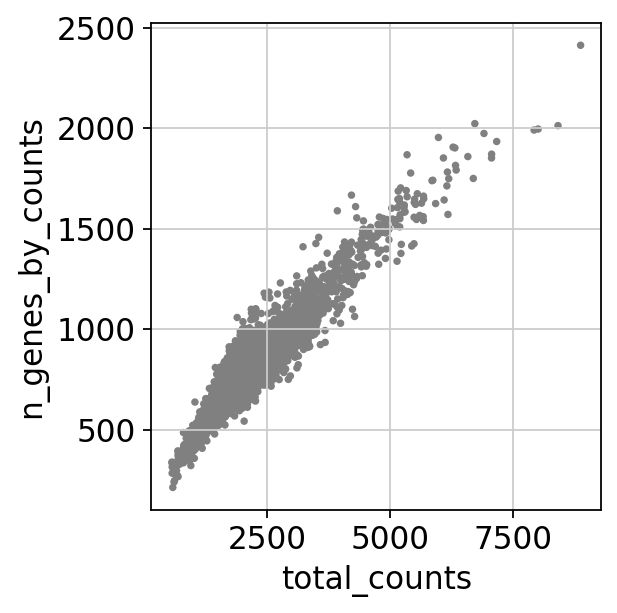

In [28]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Logarithmize the data:**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* sc.pp.log1p(adata)

>* A log-transformation to the gene expression data in adata.

>* **log1p** function takes the natural logarithm (base e) of each element in the input array, after adding 1 to each element. 
>>* The purpose of adding 1 to each element before taking the logarithm is 
>>>* to avoid taking the logarithm of 0 or negative values, 
>>>>* which can lead to errors or undefined values.

>* Log-transforming the gene expression data can be beneficial in scRNA-seq data analysis for several reasons. 
>>* First,
>>>* The distribution of gene expression counts is typically highly skewed, with a small number of highly expressed genes and a large number of genes expressed at low levels. 
>>>* Log-transforming the data can help to reduce the impact of highly expressed genes and make the distribution more symmetric, which can be beneficial for downstream analyses such as clustering and dimensionality reduction.
>>* Second, 
>>>* log-transforming the data can also help to linearize the relationship between the mean and variance of the gene expression counts. 
>>>* This is important because many statistical methods, such as differential expression analysis, assume that the variance is constant across different mean expression levels. 
>>* However, in scRNA-seq data, the variance typically increases with increasing mean expression levels, a phenomenon known as "overdispersion". 
>>* Log-transforming the data can help to mitigate this issue and improve the accuracy of downstream analyses.

>* In summary, the log1p function is commonly used in scRNA-seq data analysis to transform the gene expression data, with the aim of reducing skewness, linearizing the mean-variance relationship, and improving the accuracy of downstream analyses.

In [29]:
sc.pp.log1p(adata)


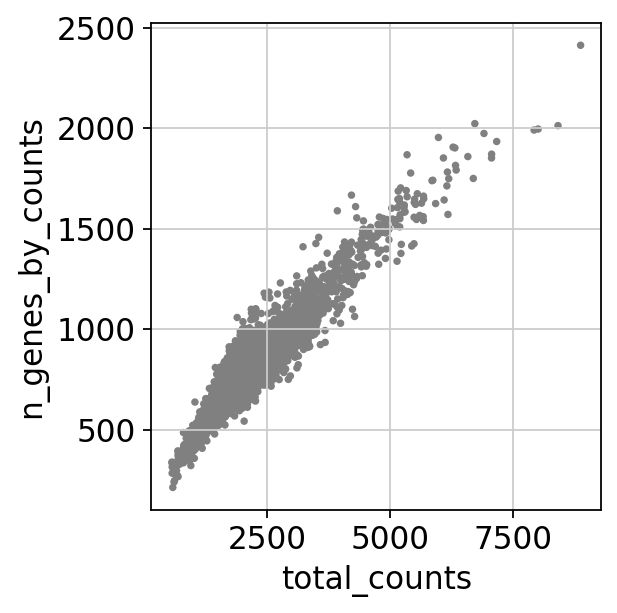

In [30]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Identify highly-variable genes.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

* sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


>* The function is used to identify highly variable genes in the scRNA-seq dataset stored in the adata object. 
>* Highly variable genes are those that show a high degree of variability in expression across cells, 
>>* which can be informative for downstream analyses such as clustering and dimensionality reduction.

>* The sc.pp.highly_variable_genes() function identifies highly variable genes based on three criteria:

>>* **Mean expression level:** Genes with mean expression levels outside a specified range are excluded. 
>>>* The min_mean and max_mean parameters are set to 0.0125 and 3, respectively. 
>>>* This means that genes with mean expression levels less than 0.0125 or greater than 3 will be excluded from the analysis.

>>* **Dispersion:** Genes with low dispersion (i.e., low variance relative to mean expression) are excluded. 
>>>* The min_disp parameter is set to 0.5, which means that genes with a dispersion less than 0.5 will be excluded from the analysis.

>>* **Expression pattern:** Genes that show a "dropout" pattern, where expression is only detected in a small number of cells, are excluded. 
>>>* This is done using a statistical test that compares the observed distribution of expression levels to a null distribution.

>* By identifying highly variable genes using these criteria, the sc.pp.highly_variable_genes() function helps to reduce the impact of noise and technical variation in downstream analyses, and focuses on the genes that are most informative for characterizing cell types and states.



In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


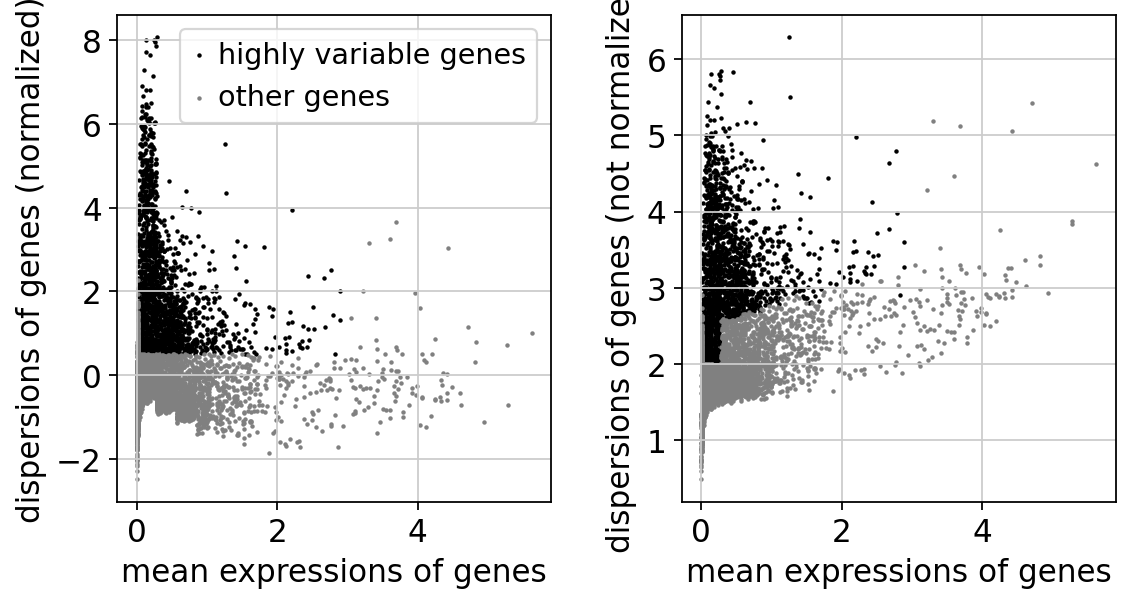

In [32]:
sc.pl.highly_variable_genes(adata)

In [33]:
adata.raw = adata

* adata = adata[:, adata.var.highly_variable]

>* This is used to subset the adata object to include only the highly variable genes identified by the sc.pp.highly_variable_genes() function.

>>* adata.var.highly_variable returns a Boolean vector 
>>>* indicating which genes in adata.var are considered highly variable based on the criteria specified.
>* The [:, adata.var.highly_variable] indexing syntax is used to subset the adata object to include all cells, but only the highly variable genes. 
>* This creates a new adata object that contains only the most informative genes for downstream analyses, reducing the dimensionality of the data and improving the interpretability of clustering and dimensionality reduction results.


In [34]:
adata = adata[:, adata.var.highly_variable]

In [35]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [36]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [37]:
sc.pp.scale(adata, max_value=10)

In [38]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


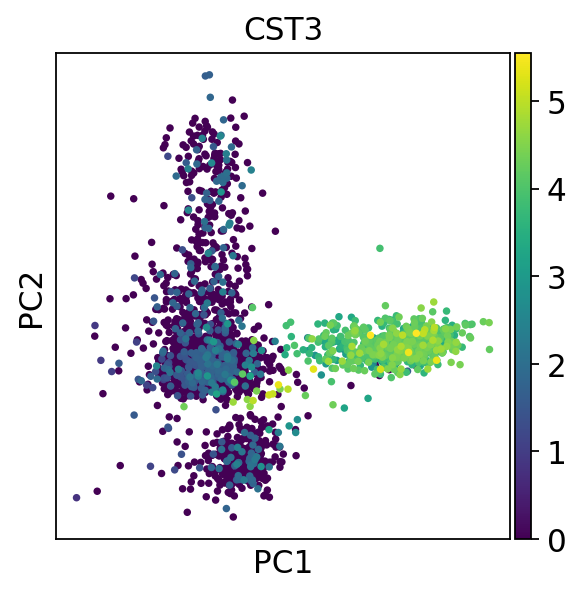

In [39]:
sc.pl.pca(adata, color='CST3')

In [40]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

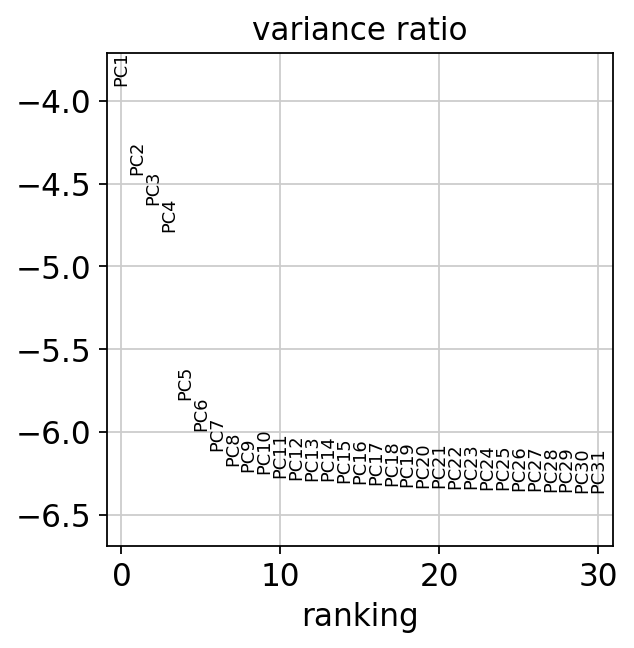

In [41]:
sc.pl.pca_variance_ratio(adata, log=True)


**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Save the result.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [42]:
adata.write(results_file)

## **Computing the neighborhood graph**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [43]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## **Embedding the neighborhood graph**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:


```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [44]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


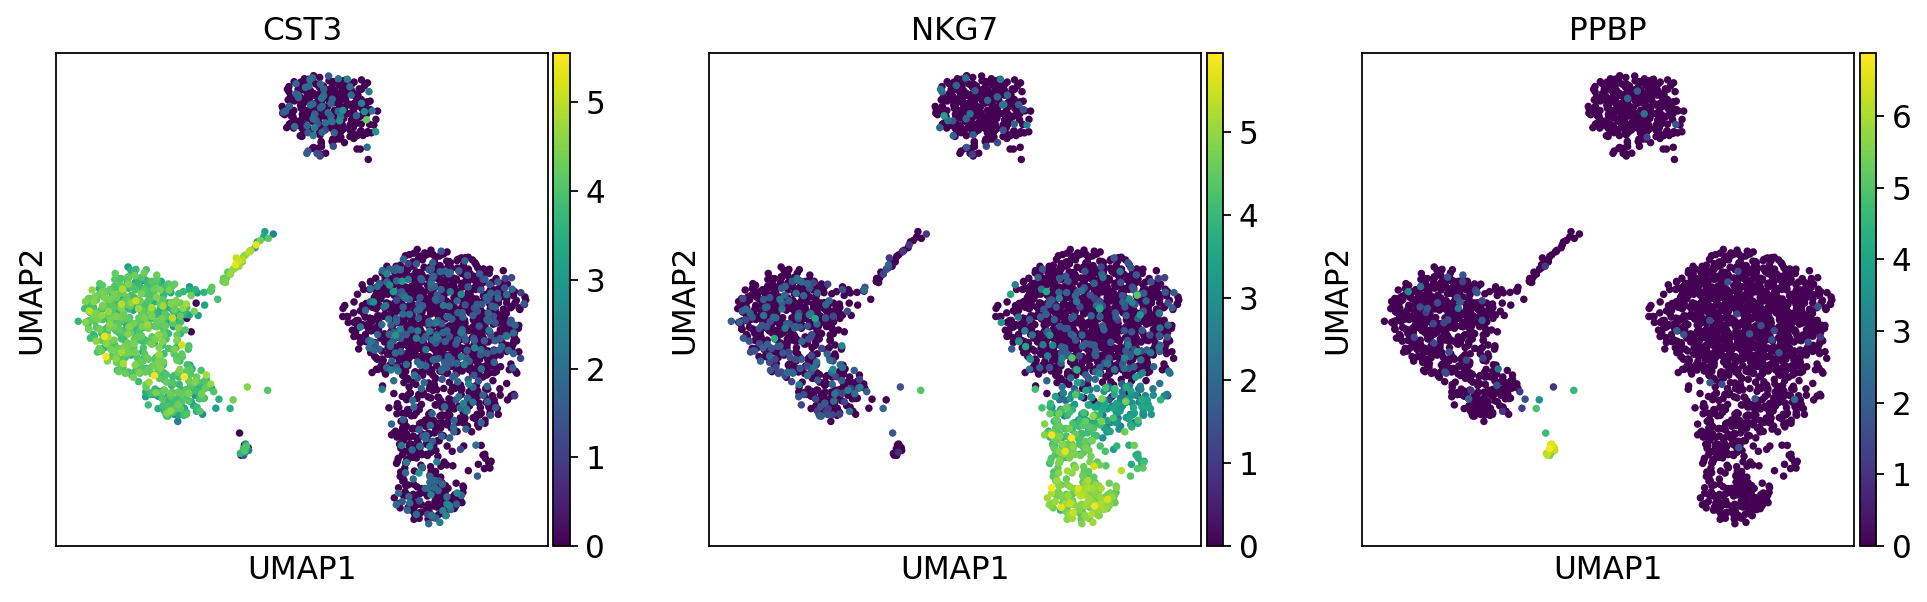

In [45]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## **Clustering the neighborhood graph**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [46]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


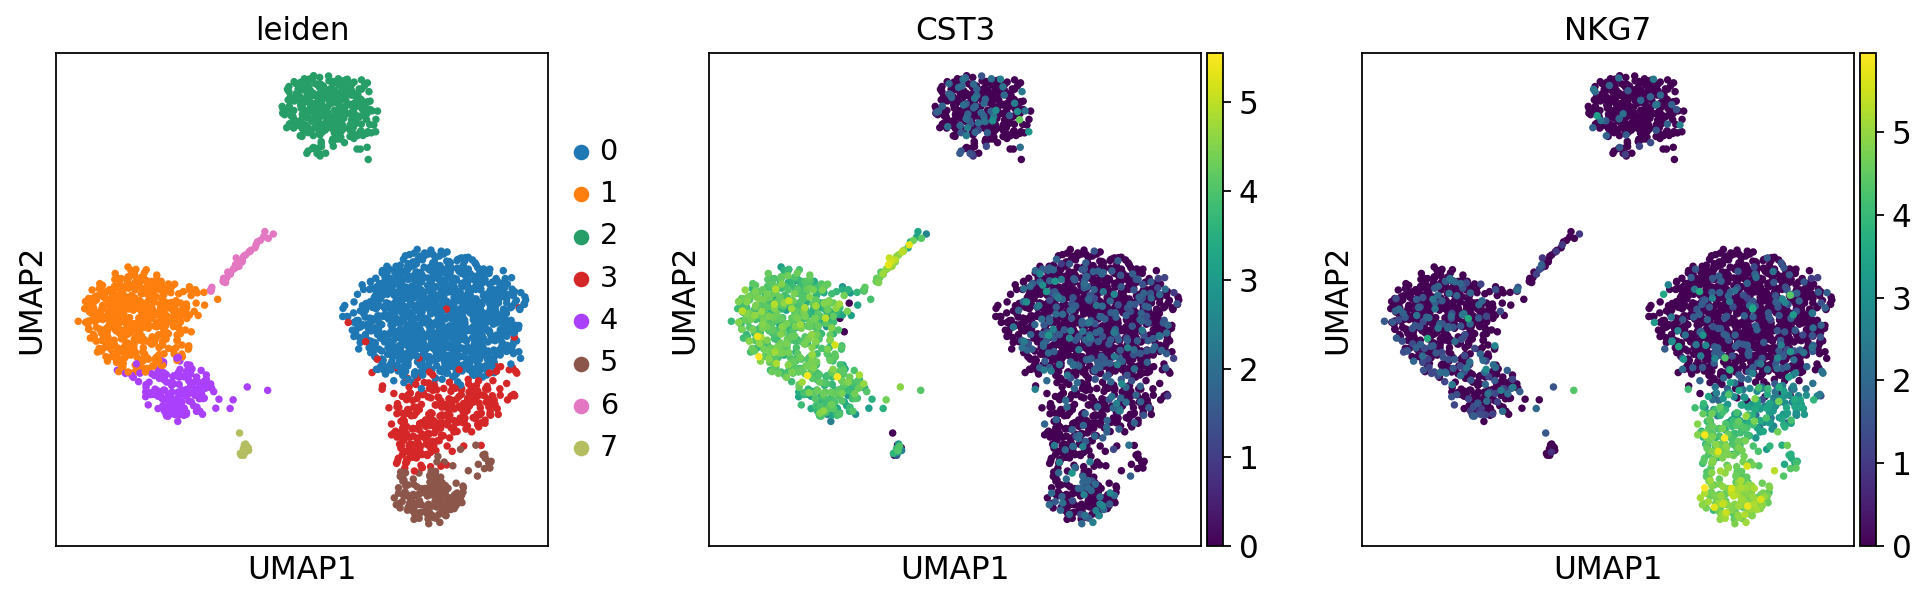

In [47]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Save the result.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [48]:
adata.write(results_file)

## **Finding marker genes**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


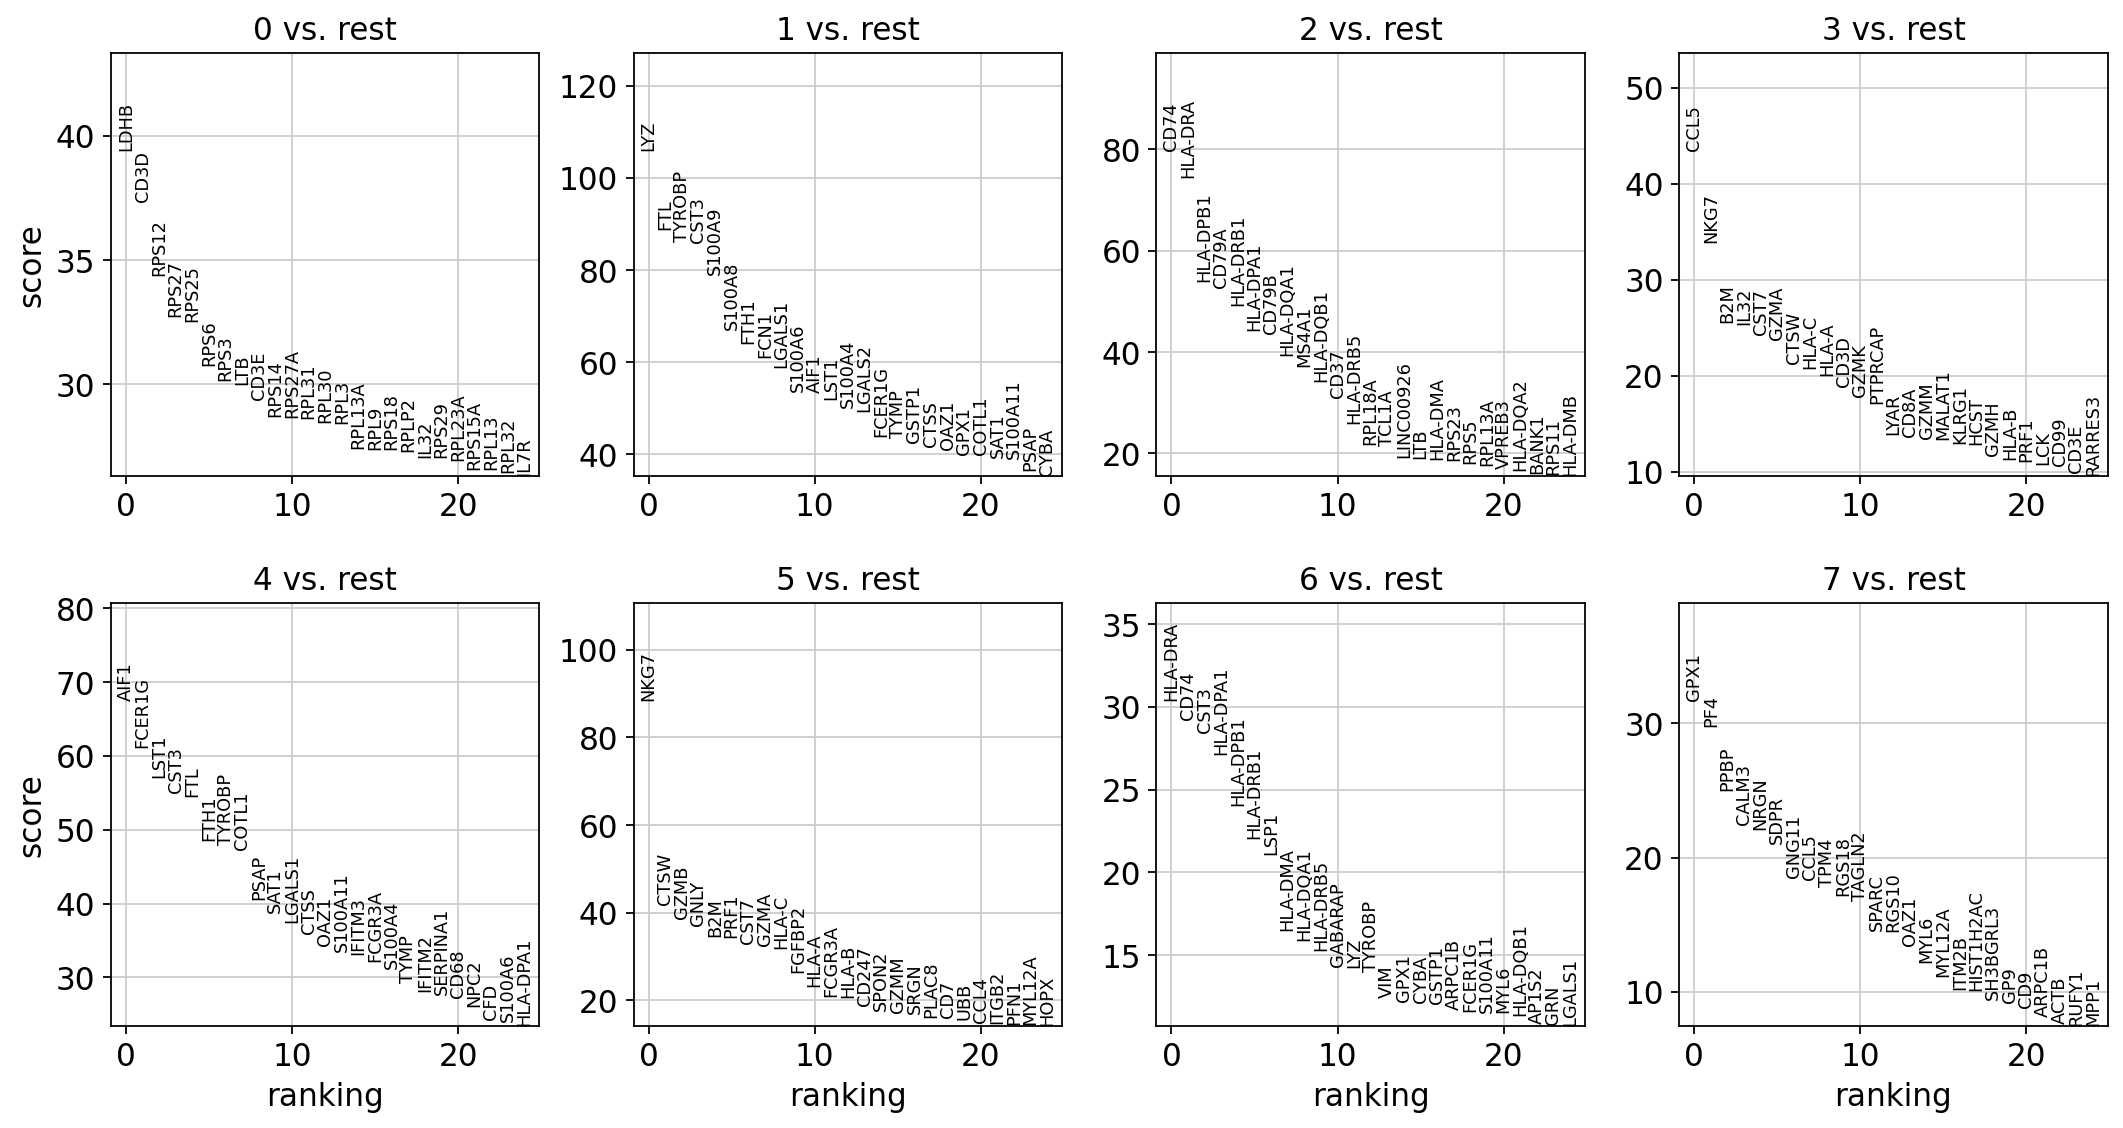

In [49]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
sc.settings.verbosity = 2  # reduce the verbosity

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

ranking genes
    finished (0:00:01)


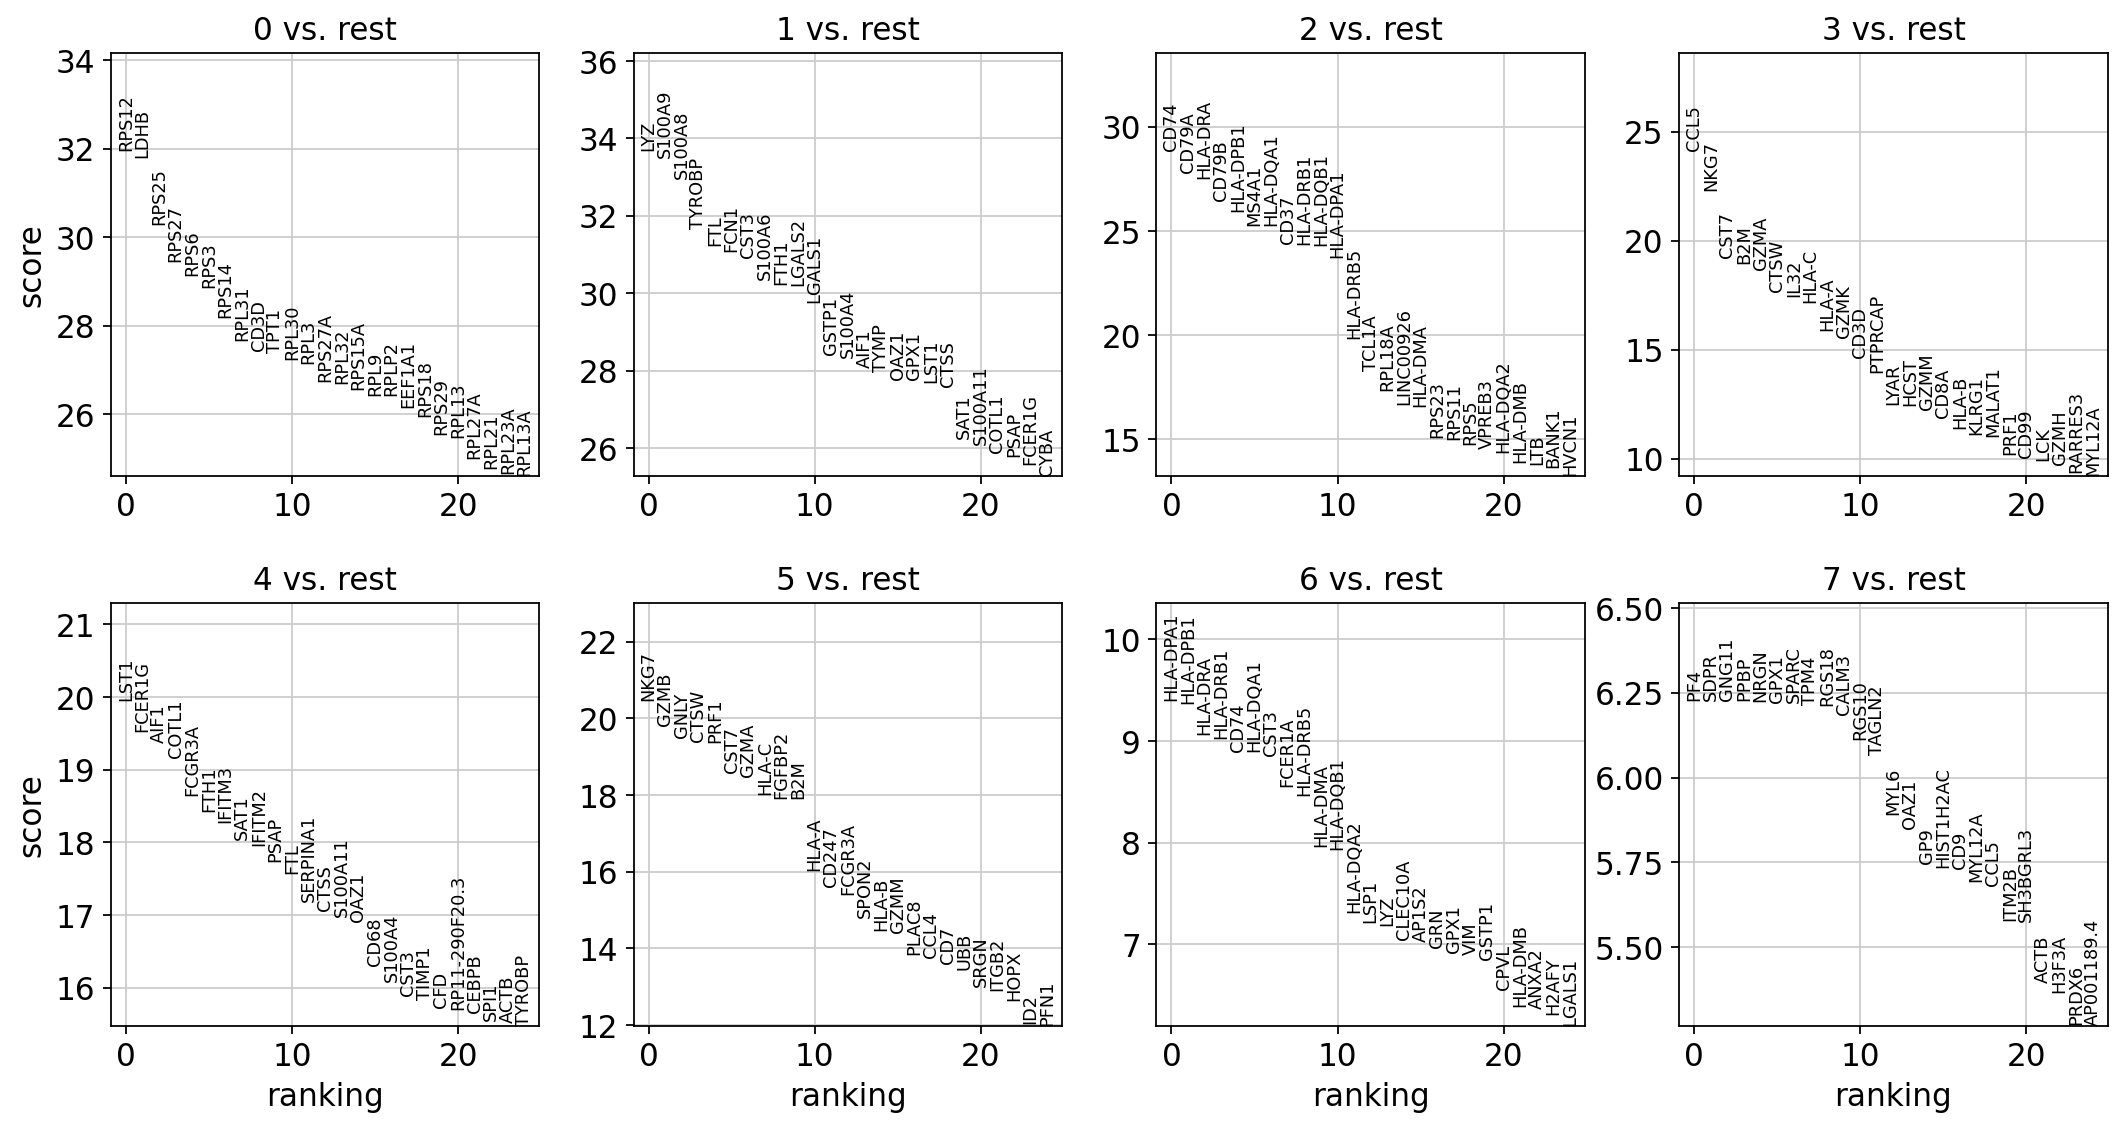

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Save the result.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [52]:
adata.write(results_file)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

ranking genes
    finished (0:00:05)


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


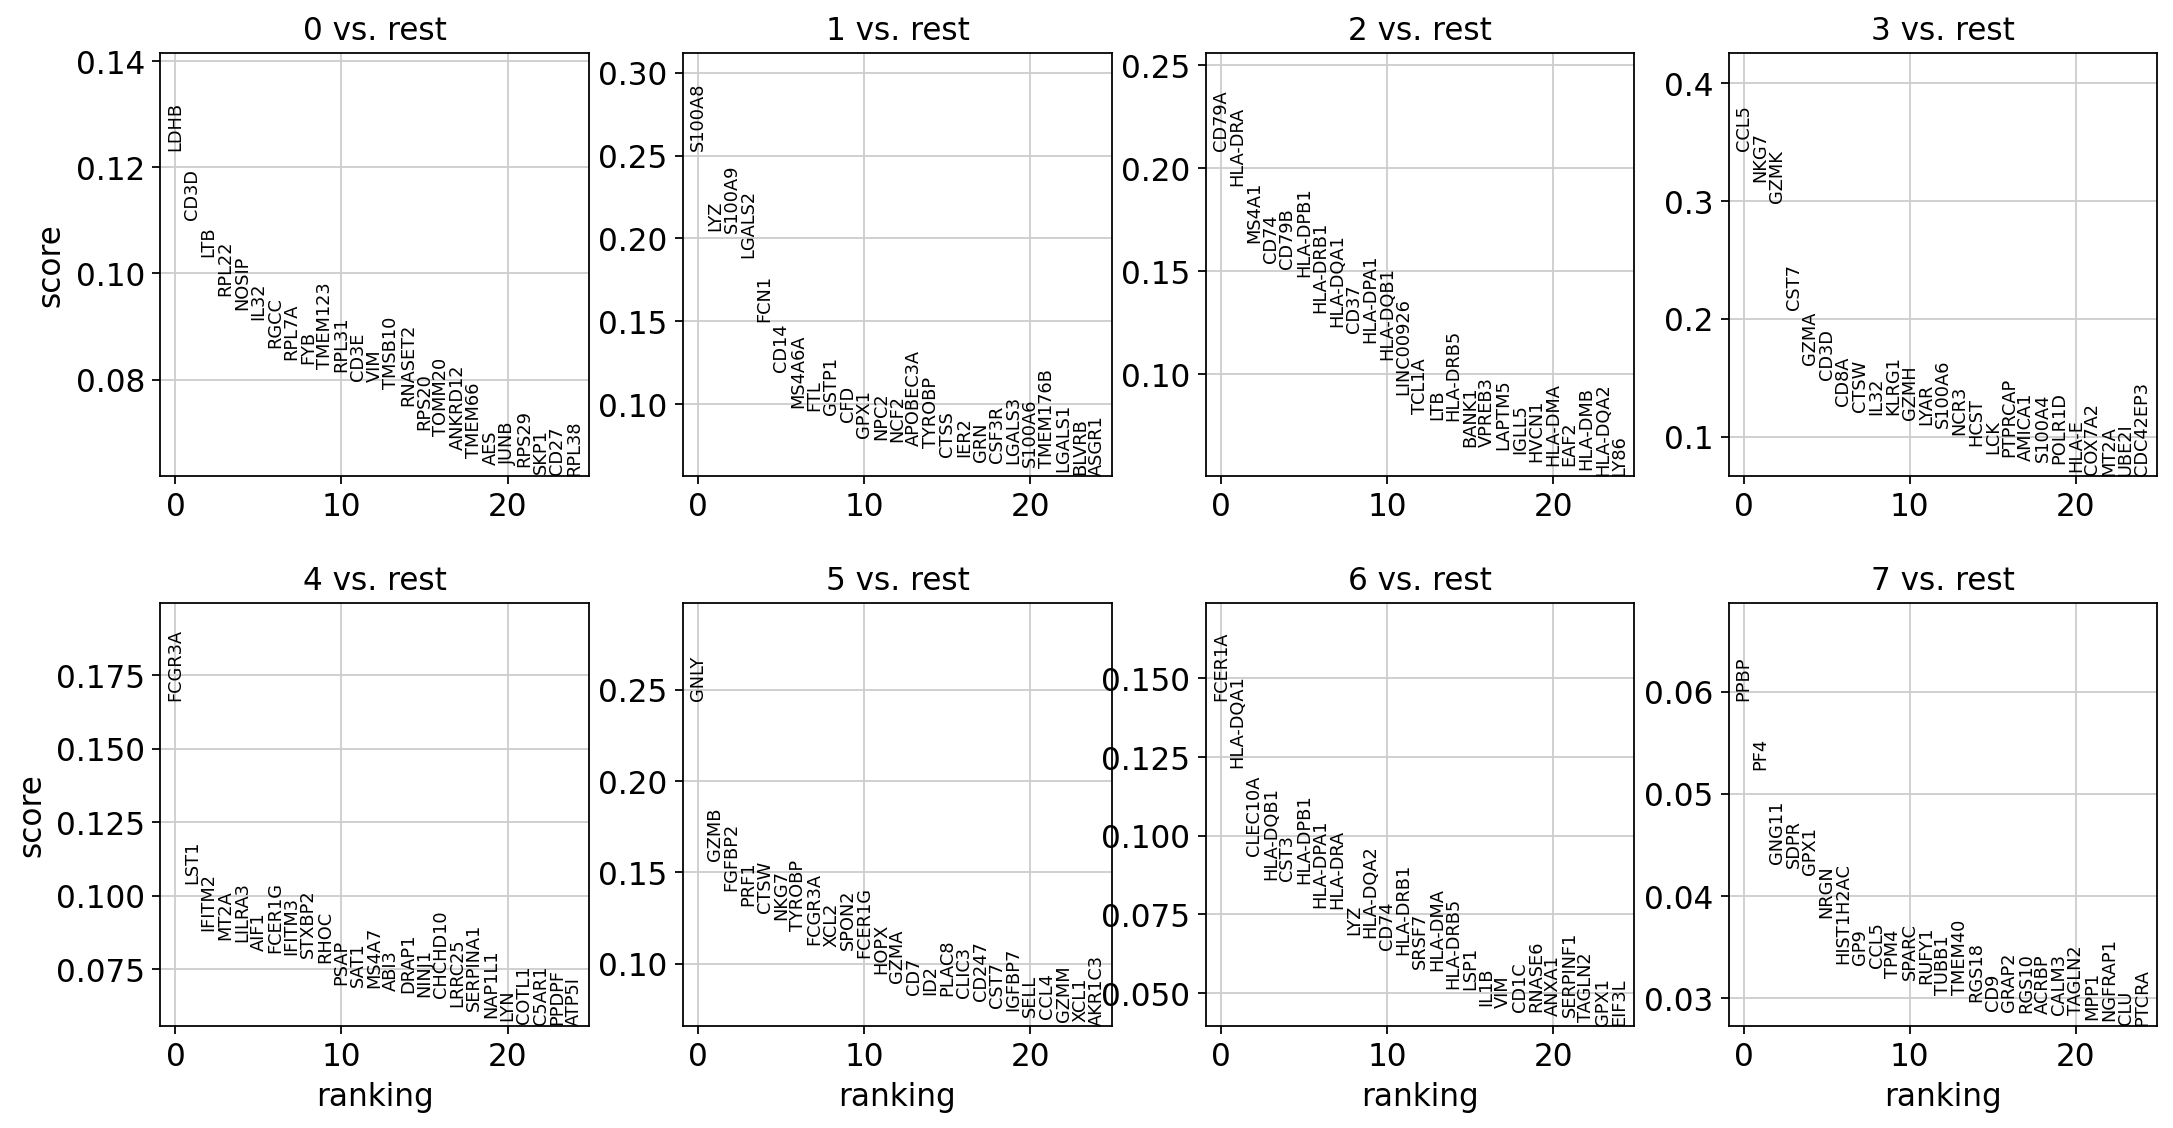

In [53]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.**

Louvain Group | Markers | Cell Type
--|-----|----
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes


**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Let us also define a list of marker genes for later reference.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [54]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Reload the object that has been save with the Wilcoxon Rank-Sum test result.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [55]:
adata = sc.read(results_file)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [56]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,FCER1G,GZMB,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,CST7,AIF1,GNLY,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,B2M,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,FCGR3A,PRF1,CD74,NRGN


**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Get a table with the scores and groups.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [57]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,3.912944e-224,LYZ,7.634876e-249,CD74,2.487145e-183,CCL5,8.117814e-129,LST1,1.322111e-88,NKG7,3.591782e-93,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,8.876981e-222,S100A9,4.626358e-246,CD79A,1.679730e-170,NKG7,3.330417e-110,FCER1G,6.259712e-85,GZMB,2.033412e-87,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.632646e-201,S100A8,1.622835e-238,HLA-DRA,6.942399e-167,CST7,2.774346e-82,AIF1,1.348814e-83,GNLY,8.130223e-85,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,1.058451e-190,TYROBP,2.957652e-220,CD79B,2.569135e-154,B2M,5.336524e-80,COTL1,5.974694e-82,CTSW,6.944632e-84,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,1.440028e-186,FTL,2.479195e-214,HLA-DPB1,3.580735e-148,GZMA,4.484064e-78,FCGR3A,1.392377e-77,PRF1,1.621421e-83,CD74,5.853161e-19,NRGN,4.800511e-10


**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Compare to a single cluster:**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [58]:
# Check if 'log1p' key is in the uns attribute of adata and if 'base' key is missing in it
if 'log1p' in adata.uns_keys() and 'base' not in adata.uns['log1p']:
    adata.uns['log1p']['base'] = None

# Run rank_genes_groups function
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')


ranking genes
    finished (0:00:00)


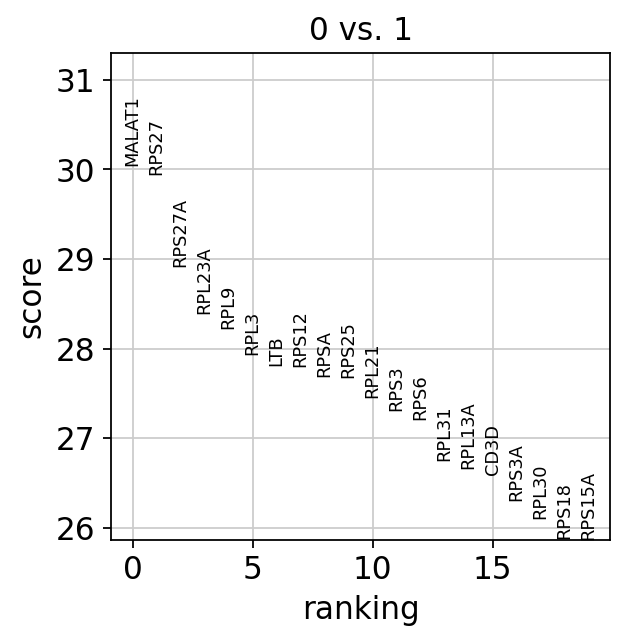

In [59]:
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


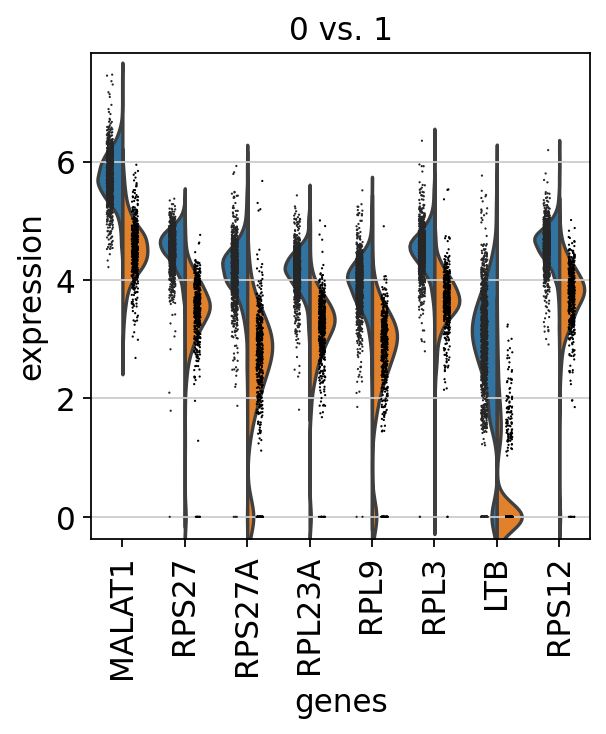

In [60]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**If you want to compare a certain gene across groups, use the following.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

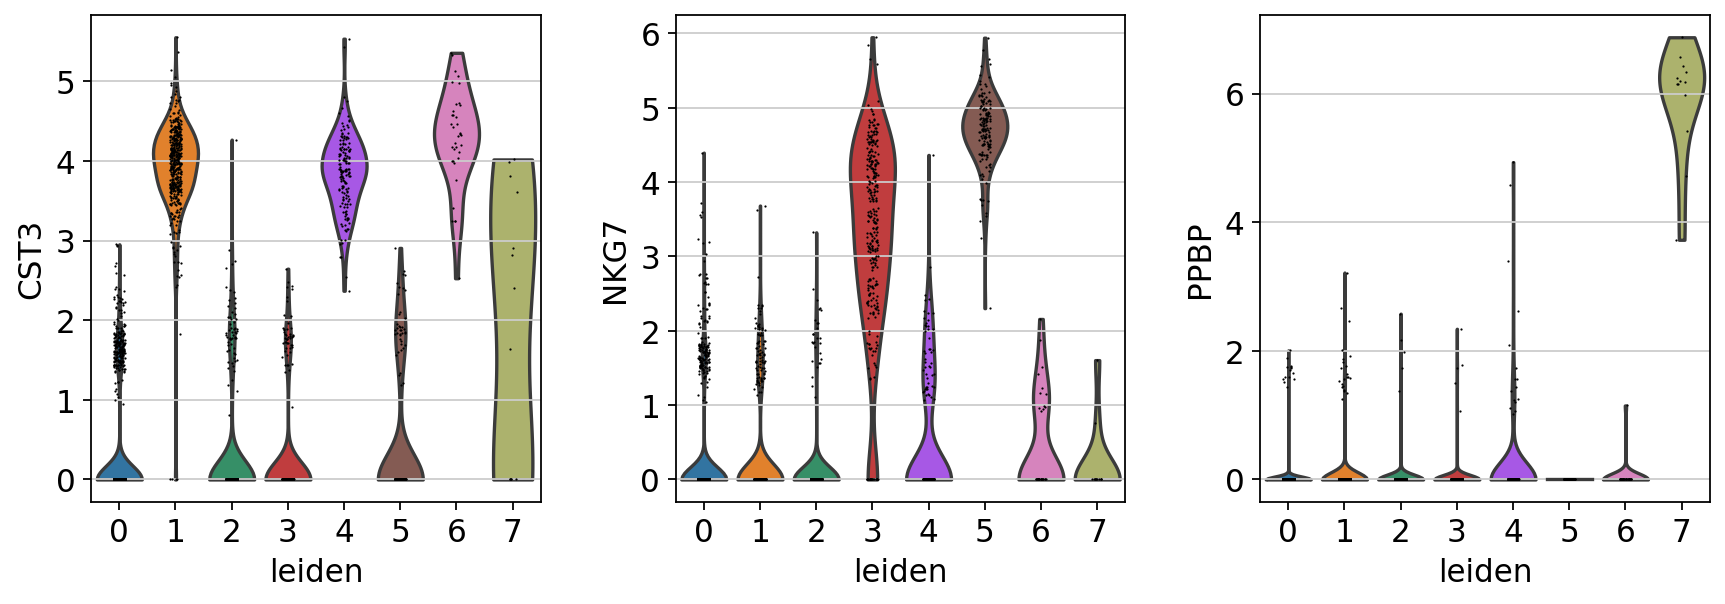

In [61]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Actually mark the cell types.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [62]:
# adata.uns['leiden_colors'] = [adata.uns['leiden_colors'][i] for i in [1, 2, 0, 3, 4, 5, 6, 7]]
# adata.obs['leiden'] = pd.Categorical(adata.obs['leiden'].cat.rename_categories(new_cluster_names))


In [63]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


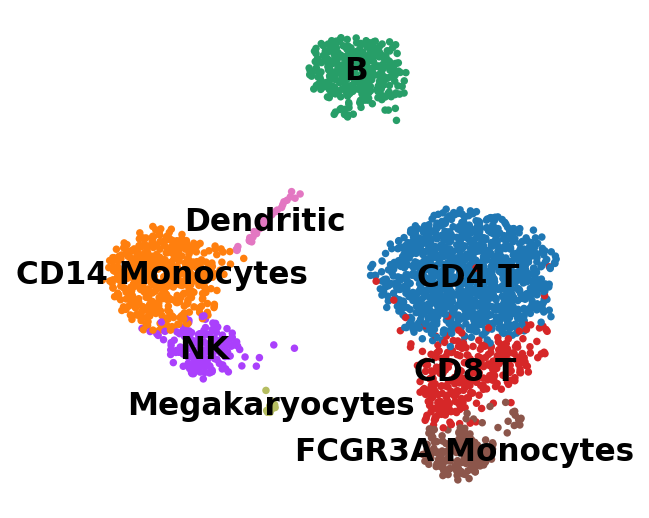

In [64]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Now that we annotated the cell types, let us visualize the marker genes.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

/home/asus/miniconda3/envs/ipy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


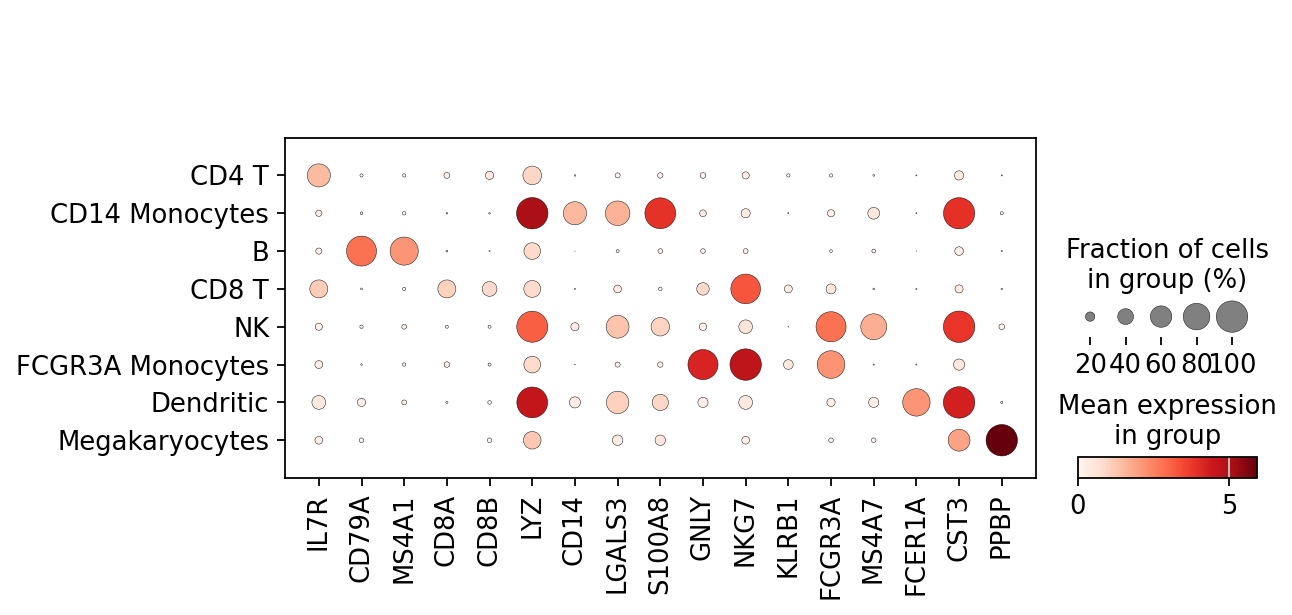

In [65]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**There is also a very compact violin plot.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

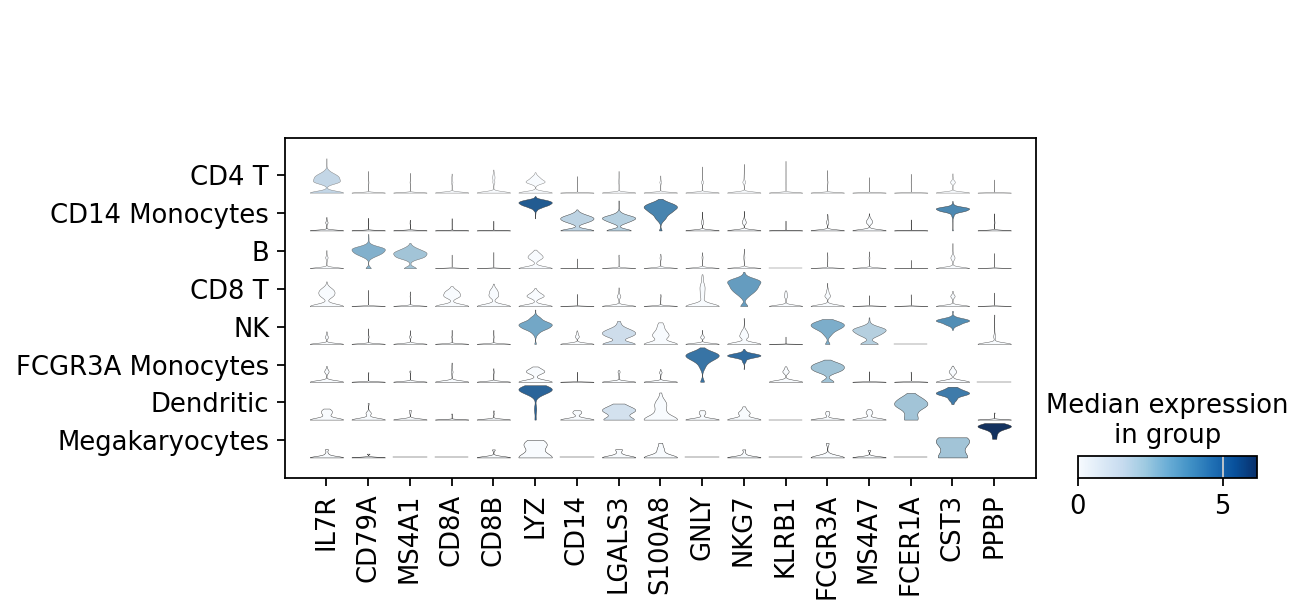

In [66]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**During the course of this analysis, the AnnData accumlated the following annotations.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [67]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [68]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.**



**If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [69]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**If you want to export to "csv", you have the following options:**

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [70]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,CD4 T
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,B
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,NK
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,FCGR3A Monocytes
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436,CD14 Monocytes
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422,B
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150,B
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795,B


In [14]:
# adata.obs[['n_counts', 'louvain_groups']].to_csv('./write/pbmc3k_corrected_louvain_groups.csv')


In [ ]:
# Export single fields of the annotation of observations
adata.obs[['n_counts', 'louvain_groups']].to_csv(
    './write/pbmc3k_corrected_louvain_groups.csv')

In [ ]:


# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/pbmc3k_corrected_X_pca.csv')


In [ ]:
# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata.write_csvs(results_file[:-5], )